# Задание 2. Распознавание образов, описываемых гауссовскими случайными векторами с одинаковыми матрицами ковариаций

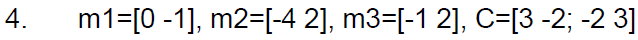

### 1. Задание исходных данных

In [1]:
import numpy as np
np.set_printoptions(precision= 5, suppress=False)

In [2]:
n = 2 #размерность признакового пространства
M = 3 #число классов
K = 10000 #количество статистических испытаний
dm = 2 #расстояние между матожиданиями вдоль координатных осей
pw = np.array([0.4, 0.2, 0.4]) #априорные вероятности классов
m = dm*np.matrix([[0, -4, -1], [-1, 2, 2]]) #матожидания (записаны как у Сироты)
C = np.matrix([[3, -2],[-2, 3]]) #матрица ковариаций
C_ = np.linalg.inv(C) #матрица, обратная к матрице ковариаций
D=1 #дисперсия

In [3]:
from numpy.linalg import cholesky
#Функция генерации совокупности гауссовских случайных векторов 
#с нулевым математическим ожиданием и матрицей ковариации С
#n-исходный порядок матрицы ковариации C (размер n*n)
#N-количество генерируемых векторов
def randncor(n,N,C):
    A=cholesky(C)
    m=n
    u=np.random.randn(m,N)
    x=np.transpose(A)*u
    return x

In [4]:
XK=np.zeros((n, M*K))
for k in range(K):
    for i in range(M):
        x_ = randncor(n,1,C)
        XK[:n, (i-1)*K+k] = (m[:,i]+x_).ravel()

### 2. Расчет разделяющих функций и вероятностей ошибок разпознавания

In [5]:
G = np.zeros((M,n+1))
P_err =  np.zeros((M,M))
l0 = np.zeros((M,M))

In [6]:
from scipy.stats import norm
for i in range(M):
    G[i,:n] = np.transpose(C_*(m[:,i]))
    G[i,n] = -0.5*np.transpose(m[:,i])*C_*m[:,i]
    for j in range(i+1,M):
        l0[i,j] = np.log(pw[j]/pw[i])
        h = 0.5*np.transpose((m[:,i]-m[:,j]))*C_*(m[:,i]-m[:,j])
        sD = np.sqrt(2*h)
        P_err[i,j] = norm.cdf(l0[i,j],h,sD)
        P_err[j,i] = 1 - norm.cdf(l0[i,j],-h,sD)
    P_err[i,i] = 1 - np.sum(P_err[i,:]) #нижняя граница вероятности правильного распознавания

In [7]:
np.set_printoptions(suppress=True)
print('Теоретическая матрица ошибок:\n {0}'.format(P_err))

Теоретическая матрица ошибок:
 [[ 0.96441  0.0067   0.02889]
 [ 0.01483  0.97034  0.01483]
 [ 0.02889  0.0067   0.96441]]


### 3.Тестирование алгоритма методом статистических испытаний

In [8]:
#Функция для вычисления экспериментальной матрицы ошибок
def experiment_error(K):
    x=np.matrix(np.ones((n+1, 1)))
    P_err_experiment=np.zeros((M, M)) #экспериментальная матрица ошибок
    for k in range(K): #цикл по испытаниям
        for i in range(M): #цикл по классам
            x_=randncor(n, 1, C)
            x[:n,0]=m[:,i]+x_ #генерация образов i-го класса
            u=G*x+np.log(np.transpose(pw)) #вычисление значения разделяющих функций
            u_max=u.max()
            u_max_num=np.where(u==u_max)[0]
            P_err_experiment[i, u_max_num]+=1
    P_err_experiment/=K
    return P_err_experiment

In [9]:
sample_size=[10, 100, 1000, 10000]
errors=[experiment_error(i) for i in sample_size]

In [10]:
for i in range(len(sample_size)):
    print('Образов в одном классе: '+ format(sample_size[i]))
    print('Экспериментальная матрица ошибок:\n{0}\n'.format(errors[i]))

Образов в одном классе: 10
Экспериментальная матрица ошибок:
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]

Образов в одном классе: 100
Экспериментальная матрица ошибок:
[[ 0.99  0.01  0.  ]
 [ 0.02  0.95  0.03]
 [ 0.01  0.04  0.95]]

Образов в одном классе: 1000
Экспериментальная матрица ошибок:
[[ 0.971  0.023  0.006]
 [ 0.003  0.953  0.044]
 [ 0.01   0.034  0.956]]

Образов в одном классе: 10000
Экспериментальная матрица ошибок:
[[ 0.9717  0.019   0.0093]
 [ 0.0073  0.9544  0.0383]
 [ 0.0056  0.0406  0.9538]]



### 4.Визуализация

In [11]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [12]:
xMin = m[0, :].min() - 4*np.sqrt(D)
xMax = m[0, :].max() + 4*np.sqrt(D)
yMin = m[1, :].min() - 4*np.sqrt(D)
yMax = m[1, :].max() + 4*np.sqrt(D)

In [13]:
def draw_areas():
    step=0.05
    x, y = np.mgrid[xMin:xMax:step, yMin:yMax:step] #x и y от минимального до максимального
    xy = np.dstack((x, y)) #все возможные комбинации x и y
    for i in range(M): #рисуем контур для каждого облака
        rv = multivariate_normal(np.array(m)[:, i], C)
        plt.contour(x, y, rv.pdf(xy))

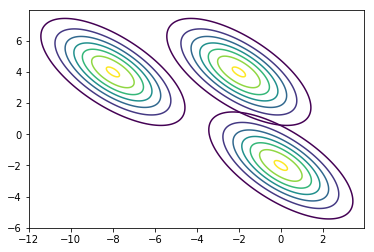

In [14]:
draw_areas()
plt.show()

In [15]:
def draw_points():
    plt.plot(XK[0, :K], XK[1, :K], 'bo')
    plt.plot(XK[0, K:2*K], XK[1, K:2*K], 'ro')
    plt.plot(XK[0, 2*K:3*K], XK[1, 2*K:3*K], 'go')    

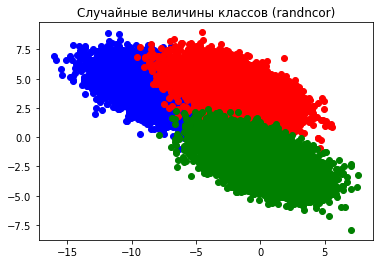

In [16]:
draw_points()
plt.title('Случайные величины классов (randncor)');
plt.show()

In [17]:
def generate_points(m, C, n):
    vals = np.zeros((M, 2, n))
    for i in range(0, M):
        rv = multivariate_normal(np.array(m)[:, i], C)
        for j in range(0, n):
            x, y = rv.rvs()
            vals[i, 0:2, j] = rv.rvs()            
    return vals

def draw_points(points, plot):    
    colors = ['r', 'g', 'b']    
    for i in range(0, M):
        plot.scatter(points[i, 0, :], points[i, 1, :], c=colors[i], s=10)

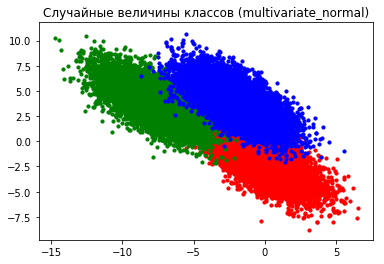

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
vals = generate_points(m, C, K)
draw_points(vals, ax)
plt.title('Случайные величины классов (multivariate_normal)')
plt.show()

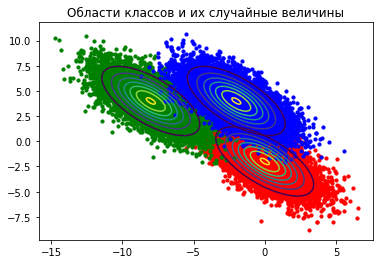

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
draw_points(vals, ax)
draw_areas()
plt.title('Области классов и их случайные величины')
plt.show()

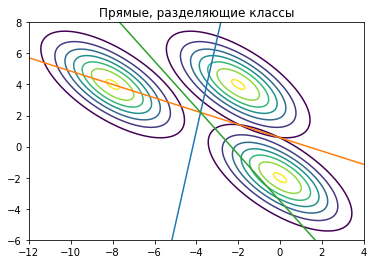

In [20]:
def draw_lines():
    for i in range(0, M):
        for j in range(i+1, M):
            A = C_.dot(np.array(m)[:, [i]] - np.array(m)[:, [j]])
            B = -0.5*(np.array(m)[:, i] + np.array(m)[:, j]) * C_ * (np.array(m)[:, [i]] - np.array(m)[:, [j]]) - np.log(1)            
            k = -A.item(0) / A.item(1)
            b = -B.item(0) / A.item(1)
            y1 = k*xMin + b
            y2 = k*xMax + b
            ax.plot([xMin, xMax], [y1, y2])          

fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis((xMin, xMax, yMin, yMax))
draw_lines()
draw_areas()
plt.title('Прямые, разделяющие классы')
plt.show()